In [12]:
!pip -qq install modAL
!pip install --upgrade -qq xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.9 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import modAL 
from modAL.models import ActiveLearner, CommitteeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.tree import DecisionTreeRegressor
import random

In [14]:
random.seed(42)
np.random.seed(42)

In [15]:
def dataloader(data_category):
  x = np.load(f"/content/{data_category}_FEATURES_60.npy")
  y = np.load(f"/content/{data_category}_LABELS_60.npy")
  x = np.delete(x,[23,55,4,9,52,44,45,33,43,20,1,50], axis=0)
  y = np.delete(y,[23,55,4,9,52,44,45,33,43,20,1,50], axis=0)
  return x,y

In [16]:
X_FVC,y_FVC = dataloader("FVC")
X_FEV1,y_FEV1 = dataloader("FEV1")
X_PEF,y_PEF = dataloader("PEF")

##**Single Task Single Output**

In [17]:
def loocv(model, X, y):
  results = []
  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = np.abs((y_test - y_pred) / y_test) * 100
    results.append(mape)
  mape_results = np.mean(results) 
  return mape_results

In [18]:
def loocv_committee_fvc(X, y):
  results = []
  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    learners = [ActiveLearner(GradientBoostingRegressor(loss='absolute_error',random_state=42),X_training=X_train, y_training=y_train),
                ActiveLearner(GradientBoostingRegressor(loss='absolute_error',random_state=1008),X_training=X_train, y_training=y_train),
                ActiveLearner(estimator=RandomForestRegressor(random_state=42),X_training=X_train, y_training=y_train)
              ]
    committee = CommitteeRegressor(learner_list=learners)
    pred, std = committee.predict(X_test, return_std=True)
    mape = np.abs((y_test - pred) / y_test) * 100
    results.append(mape)
  mape_results = np.mean(results)
  return mape_results

In [19]:
def loocv_committee_fev(X, y):
  results = []
  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    learners = [ActiveLearner(GradientBoostingRegressor(loss='absolute_error',random_state=42),X_training=X_train, y_training=y_train),
                ActiveLearner(GradientBoostingRegressor(loss='absolute_error',random_state=1008),X_training=X_train, y_training=y_train),
                ActiveLearner(RandomForestRegressor(random_state=42),X_training=X_train, y_training=y_train),
                ActiveLearner(xgb.XGBRegressor(random_state=42,objective ='reg:squarederror'),X_training=X_train, y_training=y_train)
              ]
    committee = CommitteeRegressor(learner_list=learners)
    pred, std = committee.predict(X_test, return_std=True)
    mape = np.abs((y_test - pred) / y_test) * 100
    results.append(mape)
  mape_results = np.mean(results)
  return mape_results

In [20]:
def loocv_committee_pef(X, y):
  results = []
  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    learners = [ActiveLearner(xgb.XGBRegressor(random_state=42,objective ='reg:squarederror'),X_training=X_train, y_training=y_train),
                ActiveLearner(DecisionTreeRegressor(random_state = 42),X_training=X_train, y_training=y_train),
                ActiveLearner(RandomForestRegressor(random_state=42),X_training=X_train, y_training=y_train)
              ]
    committee = CommitteeRegressor(learner_list=learners)
    pred, std = committee.predict(X_test, return_std=True)
    mape = np.abs((y_test - pred) / y_test) * 100
    results.append(mape)
  mape_results = np.mean(results)
  return mape_results

In [21]:
model = RandomForestRegressor(random_state=42)
rf_fvc = loocv(model,X_FVC,y_FVC)
rf_pef = loocv(model,X_PEF,y_PEF)
rf_fev = loocv(model,X_FEV1,y_FEV1)

rf_stso = [rf_fev,rf_fvc,rf_pef]

In [22]:
rf_stso

[6.159878474518751, 5.485491500357955, 6.965109058127212]

In [23]:
committee_fvc = loocv_committee_fvc(X_FVC,y_FVC)
committee_pef = loocv_committee_pef(X_PEF,y_PEF)
committee_fev = loocv_committee_fev(X_FEV1,y_FEV1)

committee_stso = [committee_fev, committee_fvc, committee_pef]

In [24]:
committee_stso

[5.802979334056263, 4.902589676908126, 6.047798224617073]

##**Multi Task Single Output**

In [25]:
random.seed(42)
np.random.seed(42)

In [26]:
X = concatenated_dataset = np.concatenate((X_FVC, X_FEV1, X_PEF), axis=1)

In [27]:
X_FVC.shape,X_PEF.shape,X_FEV1.shape,X.shape

((48, 155), (48, 166), (48, 166), (48, 487))

In [28]:
def loocv_mtso(model, X, y):
  results = []
  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = np.abs((y_test - y_pred) / y_test) * 100
    results.append(mape)
  mape_results = np.mean(results) 
  return mape_results

In [29]:
def loocv_committee_mtso(X, y):
  results = []
  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    learners = [ActiveLearner(GradientBoostingRegressor(loss='absolute_error',random_state=42),X_training=X_train, y_training=y_train),
                ActiveLearner(GradientBoostingRegressor(loss='absolute_error',random_state=1008),X_training=X_train, y_training=y_train),
                ActiveLearner(RandomForestRegressor(random_state=42),X_training=X_train, y_training=y_train),
                ActiveLearner(xgb.XGBRegressor(random_state=42,objective ='reg:squarederror'),X_training=X_train, y_training=y_train)
              ]
    committee = CommitteeRegressor(learner_list=learners)
    pred, std = committee.predict(X_test, return_std=True)
    mape = np.abs((y_test - pred) / y_test) * 100
    results.append(mape)
  mape_results = np.mean(results)
  return mape_results

In [30]:
model = RandomForestRegressor(random_state=42)
rf_fvc = loocv_mtso(model,X,y_FVC)
rf_pef = loocv_mtso(model,X,y_PEF)
rf_fev = loocv_mtso(model,X,y_FEV1)

In [31]:
rf_mtso = [rf_fev,rf_fvc,rf_pef]
rf_mtso

[6.641021831866887, 5.861119816428761, 7.53343477622973]

In [32]:
committee_fvc = loocv_committee_mtso(X,y_FVC)
committee_pef = loocv_committee_mtso(X,y_PEF)
committee_fev = loocv_committee_mtso(X,y_FEV1)

In [33]:
committee_mtso = [committee_fev,committee_fvc,committee_pef]
committee_mtso

[6.1393240629946275, 6.126044251632405, 7.092233512411234]

##**Multi Task Multi Output**

In [34]:
X_FVC,y_FVC = dataloader("FVC")
X_FEV1,y_FEV1 = dataloader("FEV1")
X_PEF,y_PEF = dataloader("PEF")

In [35]:
X = concatenated_dataset = np.concatenate((X_FEV1, X_FVC, X_PEF), axis=1)

y = []
for i in range(len(y_FVC)):
    y.append([y_FVC[i], y_FEV1[i], y_PEF[i]])

y = np.array(y)

In [36]:
def loocv_mtmo(model, X, y):
  results_fvc = []
  results_fev = []
  results_pef = []

  loo = LeaveOneOut()
  for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index,:], y[test_index,:]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape_fvc = np.abs((y_test[:,0] - y_pred[:,0]) / y_test[:,0]) * 100
    mape_fev = np.abs((y_test[:,1] - y_pred[:,1]) / y_test[:,1]) * 100
    mape_pef = np.abs((y_test[:,2] - y_pred[:,2]) / y_test[:,2]) * 100

    results_fvc.append(mape_fvc)
    results_fev.append(mape_fev)
    results_pef.append(mape_pef)

  mape_fvc = np.mean(results_fvc)
  mape_fev = np.mean(results_fev) 
  mape_pef = np.mean(results_pef) 

  return mape_fvc, mape_fev, mape_pef

In [37]:
model = RandomForestRegressor(random_state=42)
fvc, fev, pef = loocv_mtmo(model,X,y)

In [38]:
rf_mtmo = [fev,fvc,pef]
rf_mtmo

[6.542853934399534, 6.352333293610973, 7.601706100773323]

##**Plotting the data above**

In [40]:
# Creating dataframe having 
task_setting = np.array(['stso','stso','stso','stso','stso','stso','mtso','mtso','mtso','mtso','mtso','mtso','mtmo','mtmo','mtmo'])
model = np.array(['rf','rf','rf','committee','committee','committee','rf','rf','rf','committee','committee','committee','rf','rf','rf'])
task = np.array(['FEV1','FVC','PEF','FEV1','FVC','PEF','FEV1','FVC','PEF','FEV1','FVC','PEF','FEV1','FVC','PEF'])
mape = np.array(np.concatenate([rf_stso,committee_stso,rf_mtso,committee_mtso,rf_mtmo],axis=0))

# Creating the dataframe with specified column names
df = pd.DataFrame({'task setting': task_setting, 'task': task,'model':model,'mape':mape})
df

,task setting,task,model,mape
0,stso,FEV1,rf,6.159878
1,stso,FVC,rf,5.485492
2,stso,PEF,rf,6.965109
3,stso,FEV1,committee,5.802979
4,stso,FVC,committee,4.902590
5,stso,PEF,committee,6.047798
6,mtso,FEV1,rf,6.641022
7,mtso,FVC,rf,5.861120
8,mtso,PEF,rf,7.533435
9,mtso,FEV1,committee,6.139324


In [41]:
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/probml/probml-utils.git to /tmp/pip-req-build-wjk9ttmi
  Running command git clone --filter=blob:none --quiet https://github.com/probml/probml-utils.git /tmp/pip-req-build-wjk9ttmi
  Resolved https://github.com/probml/probml-utils.git to commit 536534e37cf8b03948e7ac5a5b5d8e62ef62057c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 KB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121

In [42]:
%env FIG_DIR = latexed
%env LATEXIFY=1

env: FIG_DIR=latexed
env: LATEXIFY=1


In [43]:
latexify(fig_width = 6, fig_height = 4)

In [44]:
fev_results =  df[(df['task']=='FEV1')]
fvc_results =  df[(df['task']=='FVC')]
pef_results =  df[(df['task']=='PEF')]

/usr/local/lib/python3.8/dist-packages/probml_utils/plotting.py:70: UserWarning: renaming latexed/loocv_results.pdf to latexed/loocv_results_latexified.pdf because LATEXIFY is True
  warnings.warn(


saving image to latexed/loocv_results_latexified.pdf
Figure size: [6. 4.]


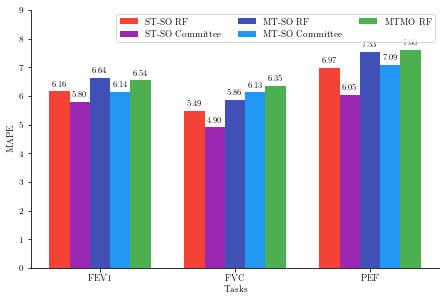

In [45]:
fig = plt.figure()
ax = fig.gca()
legend_labels = ['ST-SO RF','ST-SO Committee','MT-SO RF','MT-SO Committee','MTMO RF']
colors = ["#f44336","#9c27b0","#3f51b5","#2196f3","#4caf50"]

# Define the data
labels = ['FEV1','FVC','PEF']
data = [fev_results['mape'].tolist(),fvc_results['mape'].tolist(),pef_results['mape'].tolist()]
bar_width = 0.15
x = np.arange(len(labels))

for m,i in enumerate(zip(legend_labels,colors)):
    rects = ax.bar(x + m*bar_width, [d[m] for d in data], bar_width, label=i[0],color=i[1])


for bar in ax.patches:
    cy = bar.get_y() + bar.get_height() + 0.25
    cx = bar.get_x() + bar.get_width() / 2
    ax.text(
        cx,
        cy,
        f"{bar.get_height():.2f}",
        rotation=0,
        color="black",
        fontsize=8,
        ha="center",
        va="center",
        zorder=2,
        weight="bold",
    )
sns.despine()
# Add labels and title

x = np.arange(3)
plt.xlabel('Tasks')
plt.ylabel('MAPE')
plt.xticks(x + 0.3, ['FEV1','FVC','PEF'])
plt.legend(ncol=3)

plt.ylim(0,9)
savefig("loocv_results.pdf")
plt.show()